# Автокодировщик

In [1]:
import time

import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pylab as plt
from utils import load_dataset, iterate_minibatches
%matplotlib inline

BATCH_SIZE = 20
HIDDEN_DIM = 2

num_epochs = 40

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

## Обучение модели

tl;dr: Автокодировщик может быть использован для построения маломерных признаков данных без разметки.

В процессе обучения строится пара отображений $E: \mathbb R^D \rightarrow R^d$ (кодировщик) и $D: \mathbb R^d \rightarrow R^D$ (декодировщик), чья композиция приближает тождественное отображение:

$$ D(E(x)) \approx x $$

In [9]:
# Определим кодировщик и декодировщик с помощью пары полносвязных нейронных сетей

def ae_encoder(input_var):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
    ######################################################################################
    # Реализуйте некоторую несложную архитектуру кодировщика, возвращающую HIDDEN_DIM-мерный код #
    # Какие функции активации можно поставить на выход сети?                                  #
    ######################################################################################
    net = lasagne.layers.DenseLayer(l_in, 120)
    net = lasagne.layers.DenseLayer(net, 50)
    net = lasagne.layers.DenseLayer(net, 10)
    l_out = lasagne.layers.DenseLayer(net, HIDDEN_DIM, nonlinearity=None)
    return l_out


def ae_decoder(input_var):
    l_in = lasagne.layers.InputLayer(shape=(None, HIDDEN_DIM), input_var=input_var)
    ##################################################################################################
    # Реализуйте некоторую несложную архитектуру декодировщика, возвращающую батч объектов размера (1, 28, 28) #
    ##################################################################################################
    net = lasagne.layers.DenseLayer(l_in, 10)
    net = lasagne.layers.DenseLayer(net, 50)
    net = lasagne.layers.DenseLayer(net, 120)
    net = lasagne.layers.DenseLayer(net, 28*28, nonlinearity=T.nnet.sigmoid)
    l_out = lasagne.layers.ReshapeLayer(net, (-1, 1, 28, 28))
    return l_out

In [10]:
# Инициализируем сеть
input_x = T.tensor4('input_x')
    
encoder = ae_encoder(input_x)
decoder = ae_decoder(
    lasagne.layers.get_output(encoder)
)

Для обучения автокодировщика будем использовать среднеквадратичную ошибку

$$ L(X) = \frac{1}{N}\sum_{i=1}^{N} \sum_{j=1}^{28^2} \left( D(E(x_i))_j - x_{i,j} \right)^2 = \frac{1}{N}\sum_{i=1}^{N} (D(E(x_i)) - x_i)^T (D(E(x_i)) - x_i) $$

In [13]:
#####################################################################################
# Определите операцию для вычисления функции потерь, а также создайте список параметров модели #
# для передачи в оптимизатор                                                           #
loss = lasagne.objectives.squared_error(
    lasagne.layers.get_output(decoder), input_x
).mean()
params = lasagne.layers.get_all_params(decoder) + lasagne.layers.get_all_params(encoder)
#####################################################################################

updates = lasagne.updates.adam(loss, params)
 
train = theano.function(
    [input_x],
    loss,
    updates=updates
)
test_loss = theano.function(
    [input_x],
    loss
)

Обучение, как и во многих других случаях, выполяется с помощью стохастического градиентного спуска

In [15]:
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, batchsize=BATCH_SIZE):
        train_err += train(batch)
        train_batches += 1
        
    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, batchsize=BATCH_SIZE):
        test_err += test_loss(batch)
        test_batches += 1
        
    print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
    print("Train error {}".format(train_err/train_batches))
    print("Test error {}".format(test_err/test_batches))

Epoch 1 of 40 took 21.221s
Train error 0.05261574919186597
Test error 0.04520523052130106
Epoch 2 of 40 took 20.293s
Train error 0.04360408196544684
Test error 0.0419068140518682
Epoch 3 of 40 took 22.347s
Train error 0.04142403136767257
Test error 0.0405578702807443
Epoch 4 of 40 took 27.424s
Train error 0.040271801901459396
Test error 0.0395654445408184
Epoch 5 of 40 took 31.893s
Train error 0.039483479468340806
Test error 0.03903294015095009
Epoch 6 of 40 took 33.164s
Train error 0.03901449886412513
Test error 0.03872841030543343
Epoch 7 of 40 took 32.133s
Train error 0.03853074759117409
Test error 0.03831500017055259
Epoch 8 of 40 took 29.206s
Train error 0.03825250066825356
Test error 0.0381982448448165
Epoch 9 of 40 took 31.526s
Train error 0.03796673611365364
Test error 0.03813089603494269
Epoch 10 of 40 took 32.719s
Train error 0.03778696261854424
Test error 0.03790706291572638
Epoch 11 of 40 took 31.930s
Train error 0.03753288880072183
Test error 0.03760004647351438
Epoch 12 o

KeyboardInterrupt: 

## Визуализация

Модель с двумерными скрытыми переменными легко визуализировать. Определим две функции: одну для построения пропущенных через автокодировщик изображений, вторую для вычисления скрытых представлений по изображению

In [16]:
from utils import plot_reconstructions, plot_hidden_space

reconstruct = theano.function(
        [input_x],
        lasagne.layers.get_output(decoder)
)

encode = theano.function(
        [input_x],
        lasagne.layers.get_output(encoder)
)

Примеры изображений, пропущенных через автокодировщик: 

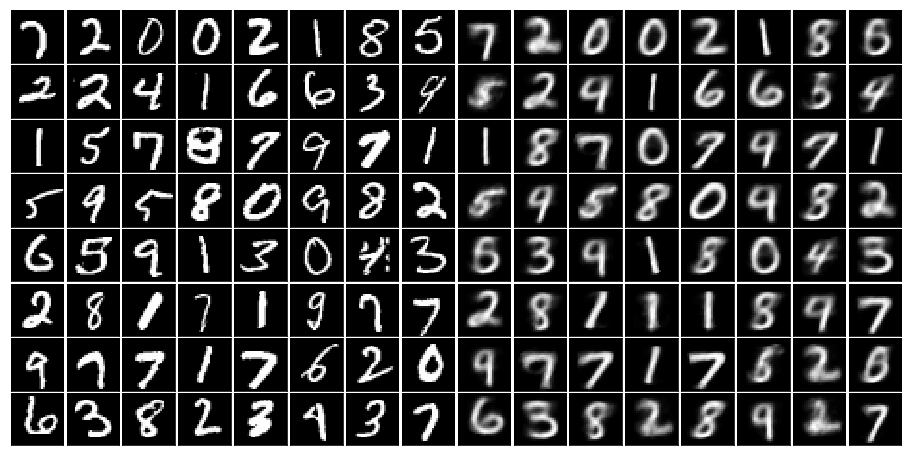

In [17]:
plot_reconstructions(X_test, reconstruct)

Визуализация признакового пространства. Насколько пространство простое? Везде ли оно плотно? Как выбрать точку в этом пространстве, которая будет соответствовать коду какого-то объекта?

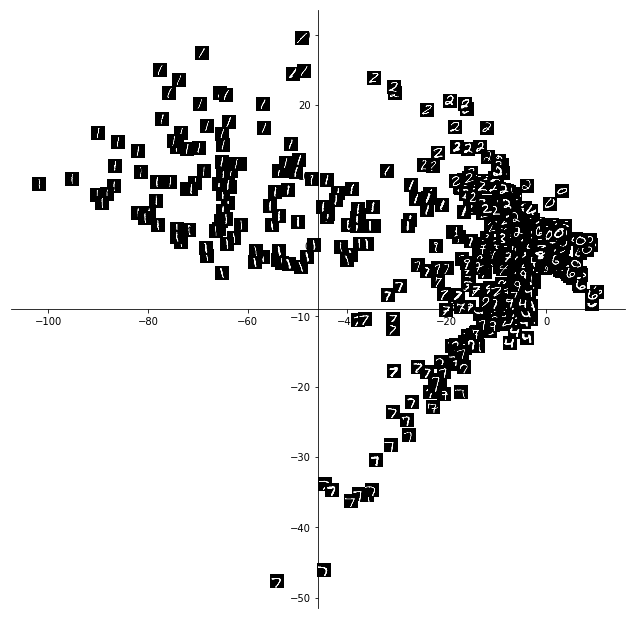

In [18]:
plot_hidden_space(X_test[:1000], encode)

Попробуйте погенерировать изображения по паре координат

In [19]:
input_z = T.matrix('input_z')

decode_a_code = theano.function(
    [input_z],
    lasagne.layers.get_output(decoder, input_z),
)

def generate_from_code(x, y):
    img = decode_a_code([[x, y]]).reshape((28, 28))
    plt.imshow(img, 'gray')

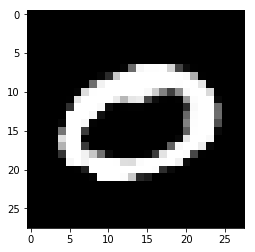

In [20]:
generate_from_code(50., 20.)